# Tutorial

In [1]:
# import modules: `pip install defigraph` or `python -m pip install -e .`
from defigraph.Graph import Graph
from defigraph.Edge import Edge
from defigraph.Vertex import Vertex
from defigraph.Pool import Pool

## 1.0 Get Decentralize Exchange (DEX) token data

In [2]:
# Option 1: Use data from cached results
import json

with open("data.json") as f:
    data = json.load(f)

In [9]:
# Option 2: Use data from API Call
import os
import requests
from dotenv import load_dotenv

load_dotenv()

api_key = os.getenv("api_key")
base_url = "https://gateway.thegraph.com/api"
# ETH-mainnet
subgraph_id = "5zvR82QoaXYFyDEKLZ9t6v9adgnptxYpKpSbxtgVENFV"  # Uniswap V3
subgraph_url = f"{base_url}/subgraphs/id/{subgraph_id}"
headers = {"Content-Type": "application/json", "Authorization": f"Bearer {api_key}"}
payload = {
    "query": "{ pools (orderBy: volumeUSD, orderDirection: desc, first: 10) { token0 { name symbol decimals id } token0Price token1Price token1 { decimals name symbol id } feeTier id } }"
}  # V3
response = requests.post(subgraph_url, headers=headers, json=payload)

# Check if the request was successful
if response.status_code == 200:
    print(response.json())
    data = response.json()["data"]["pools"]
else:
    print("Error:", response.text)

{'data': {'pools': [{'feeTier': '500', 'id': '0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640', 'token0': {'decimals': '6', 'id': '0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48', 'name': 'USD Coin', 'symbol': 'USDC'}, 'token0Price': '3139.551832890493165846815528893696', 'token1': {'decimals': '18', 'id': '0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2', 'name': 'Wrapped Ether', 'symbol': 'WETH'}, 'token1Price': '0.0003185167989659624027871142472965579'}, {'feeTier': '500', 'id': '0x11b815efb8f581194ae79006d24e0d814b7697f6', 'token0': {'decimals': '18', 'id': '0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2', 'name': 'Wrapped Ether', 'symbol': 'WETH'}, 'token0Price': '0.0003185884921817330527721139957077615', 'token1': {'decimals': '6', 'id': '0xdac17f958d2ee523a2206206994597c13d831ec7', 'name': 'Tether USD', 'symbol': 'USDT'}, 'token1Price': '3138.845327249196610967097731232173'}, {'feeTier': '100', 'id': '0x3416cf6c708da44db2624d63ea0aaef7113527c6', 'token0': {'decimals': '6', 'id': '0xa0b86991c6218b

## 1.1 Build Defi Graph

In [10]:
from web3 import Web3

edges = []

for pool in data:
    fee = pool["feeTier"]

    token0 = pool["token0"]["symbol"]
    token0_decimals = int(pool["token0"]["decimals"])
    token0_address = Web3.to_checksum_address(pool["token0"]["id"])
    token0Price = float(pool["token0Price"])

    token1 = pool["token1"]["symbol"]
    token1_decimals = int(pool["token1"]["decimals"])
    token1_address = Web3.to_checksum_address(pool["token1"]["id"])
    token1Price = float(pool["token1Price"])

    pool_address = Web3.to_checksum_address(pool["id"])

    u = Vertex(token0, token0_decimals, token0_address)
    v = Vertex(token1, token1_decimals, token1_address)

    pool = Pool(
        pool_address=pool_address,
        token0=u,
        token1=v,
        fee=fee,
        token0_price=token0Price,
        token1_price=token1Price,
    )
    pool2 = Pool(
        pool_address=pool_address,
        token0=v,
        token1=u,
        fee=fee,
        token0_price=token1Price,
        token1_price=token0Price,
    )
    edge = Edge(pool=pool)
    edge2 = Edge(pool=pool2)
    edges.append(edge)
    edges.append(edge2)

g = Graph(edges=edges)

In [11]:
print(f"No. of vertices {len(g.vertices)}")
print(f"No. of edges {len(g.get_edges())}")

No. of vertices 5
No. of edges 20


## 2. Bellman-Ford Algorithm

In [12]:
import math

all_neg_cycles = []
printable_neg_cycle = []

def bellman_ford(graph: Graph, start_vertex: Vertex):
    # 1. Initialize distances
    distances = {key: float("inf") for key in graph.vertices}
    predecessor = {key: None for key in graph.vertices}
    distances[start_vertex] = 0

    # 2. Relax edges for n - 1 steps
    for i in range(len(graph.vertices) - 1):
        for edge in g.get_edges():
            (u, v, w) = edge
            if distances[u] + w[0] < distances[v]:
                distances[v] = distances[u] + w[0]
                predecessor[v] = (u, w)

    # 3. Detect negative cycle
    for edge in g.get_edges():
        (u, v, w) = edge

        if distances[u] + w[0] < distances[v]:
            cycle = []
            # 1. add last token pool to cycle
            # 2. add 2nd last token pool to cycle
            cycle.append((w[1], w[1].address))
            cycle.append((predecessor[u][1][1], predecessor[u][1][1].address))

            # 1. use last token as start
            # 2. initialize path tracing
            # 3. initialize weight calcualtion
            # 4. start with u token predecessor
            start = v
            s = f"{v} <- {u} <- "
            c = f"{str(w[0])} + {str(predecessor[u][1][0])}"
            curr = predecessor[u][0]

            visited = set()
            visited.add(w)
            visited.add(predecessor[u][1])
            while curr != start:
                if predecessor[curr][1] in visited:
                    ###### ignoring cycles whose edge we have visted #####
                    cycle = []
                    break
                visited.add(predecessor[curr][1])
                # 1. add next path trace
                # 2. add next cycle weight
                # 3. add next token pool to path
                # 4. update next token
                s += f"{curr} <- "
                c += f" + {str(predecessor[curr][1][0])}"
                cycle.append((predecessor[curr][1][1], predecessor[curr][1][1].address))
                curr = predecessor[curr][0]

            s += f"{curr}"
            if cycle:
                print("🌟 CYCLE FOUND", w)
                print(" -> ".join(s.split(" <- ")[::-1]))
                print(f"Pools: {cycle[::-1]}")
                print(f"Profit: {math.e ** -eval(c)} = {c}\n")
                all_neg_cycles.append(cycle[::-1])
                printable_neg_cycle.append(edge)
        # break
    return distances, predecessor


bellman_ford(
    g,
    Vertex(
        "WETH",
        18,
        Web3.to_checksum_address("0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2"),
    ),
)
for i in all_neg_cycles:
    print(i)
    
print(printable_neg_cycle)

🌟 CYCLE FOUND (-0.0004320207698629015, (USDC, USDT, '100'))
USDT -> WETH -> USDC -> USDT
Pools: [((USDT, WETH, '3000'), '0x4e68Ccd3E89f51C3074ca5072bbAC773960dFa36'), ((WETH, USDC, '500'), '0x88e6A0c2dDD26FEEb64F039a2c41296FcB3f5640'), ((USDC, USDT, '100'), '0x3416cF6C708Da44DB2624D63ea0AAef7113527C6')]
Profit: 1.0024920417905614 = -0.0004320207698629015 + 8.05183534033681 + -8.053892261370496

🌟 CYCLE FOUND (-8.054184584111269, (USDC, WETH, '3000'))
WETH -> USDC -> WETH
Pools: [((WETH, USDC, '500'), '0x88e6A0c2dDD26FEEb64F039a2c41296FcB3f5640'), ((USDC, WETH, '3000'), '0x8ad599c3A0ff1De082011EFDDc58f1908eb6e6D8')]
Profit: 1.0023520054097763 = -8.054184584111269 + 8.05183534033681

🌟 CYCLE FOUND (8.051610281097563, (WETH, USDT, '500'))
USDT -> WETH -> USDT
Pools: [((USDT, WETH, '3000'), '0x4e68Ccd3E89f51C3074ca5072bbAC773960dFa36'), ((WETH, USDT, '500'), '0x11b815efB8f581194ae79006d24E0d814B7697F6')]
Profit: 1.00228458597159 = 8.051610281097563 + -8.053892261370496

🌟 CYCLE FOUND (8.05

In [13]:
math.e ** -(1.0010499537652917)

0.3674933874717443

[([USDC, WETH, (-8.051835340336812, (USDC, WETH, '500'))]), ([WETH, USDC, (8.05183534033681, (WETH, USDC, '500'))]), ([WETH, USDT, (8.051610281097563, (WETH, USDT, '500'))]), ([USDT, WETH, (-8.051610281097563, (USDT, WETH, '500'))]), ([USDC, USDT, (-0.0004320207698629015, (USDC, USDT, '100'))]), ([USDT, USDC, (0.0004320207698628343, (USDT, USDC, '100'))]), ([USDC, WETH, (-8.054184584111269, (USDC, WETH, '3000'))]), ([WETH, USDC, (8.054184584111269, (WETH, USDC, '3000'))]), ([WBTC, WETH, (3.355522729042705, (WBTC, WETH, '500'))]), ([WETH, WBTC, (-3.355522729042705, (WETH, WBTC, '500'))]), ([WETH, USDT, (8.053892261370496, (WETH, USDT, '3000'))]), ([USDT, WETH, (-8.053892261370496, (USDT, WETH, '3000'))]), ([WETH, USDT, (8.052360258480673, (WETH, USDT, '100'))]), ([USDT, WETH, (-8.052360258480673, (USDT, WETH, '100'))]), ([DAI, WETH, (-8.052410127209898, (DAI, WETH, '500'))]), ([WETH, DAI, (8.052410127209898, (WETH, DAI, '500'))]), ([WBTC, WETH, (3.356085729821921, (WBTC, WETH, '3000'))]

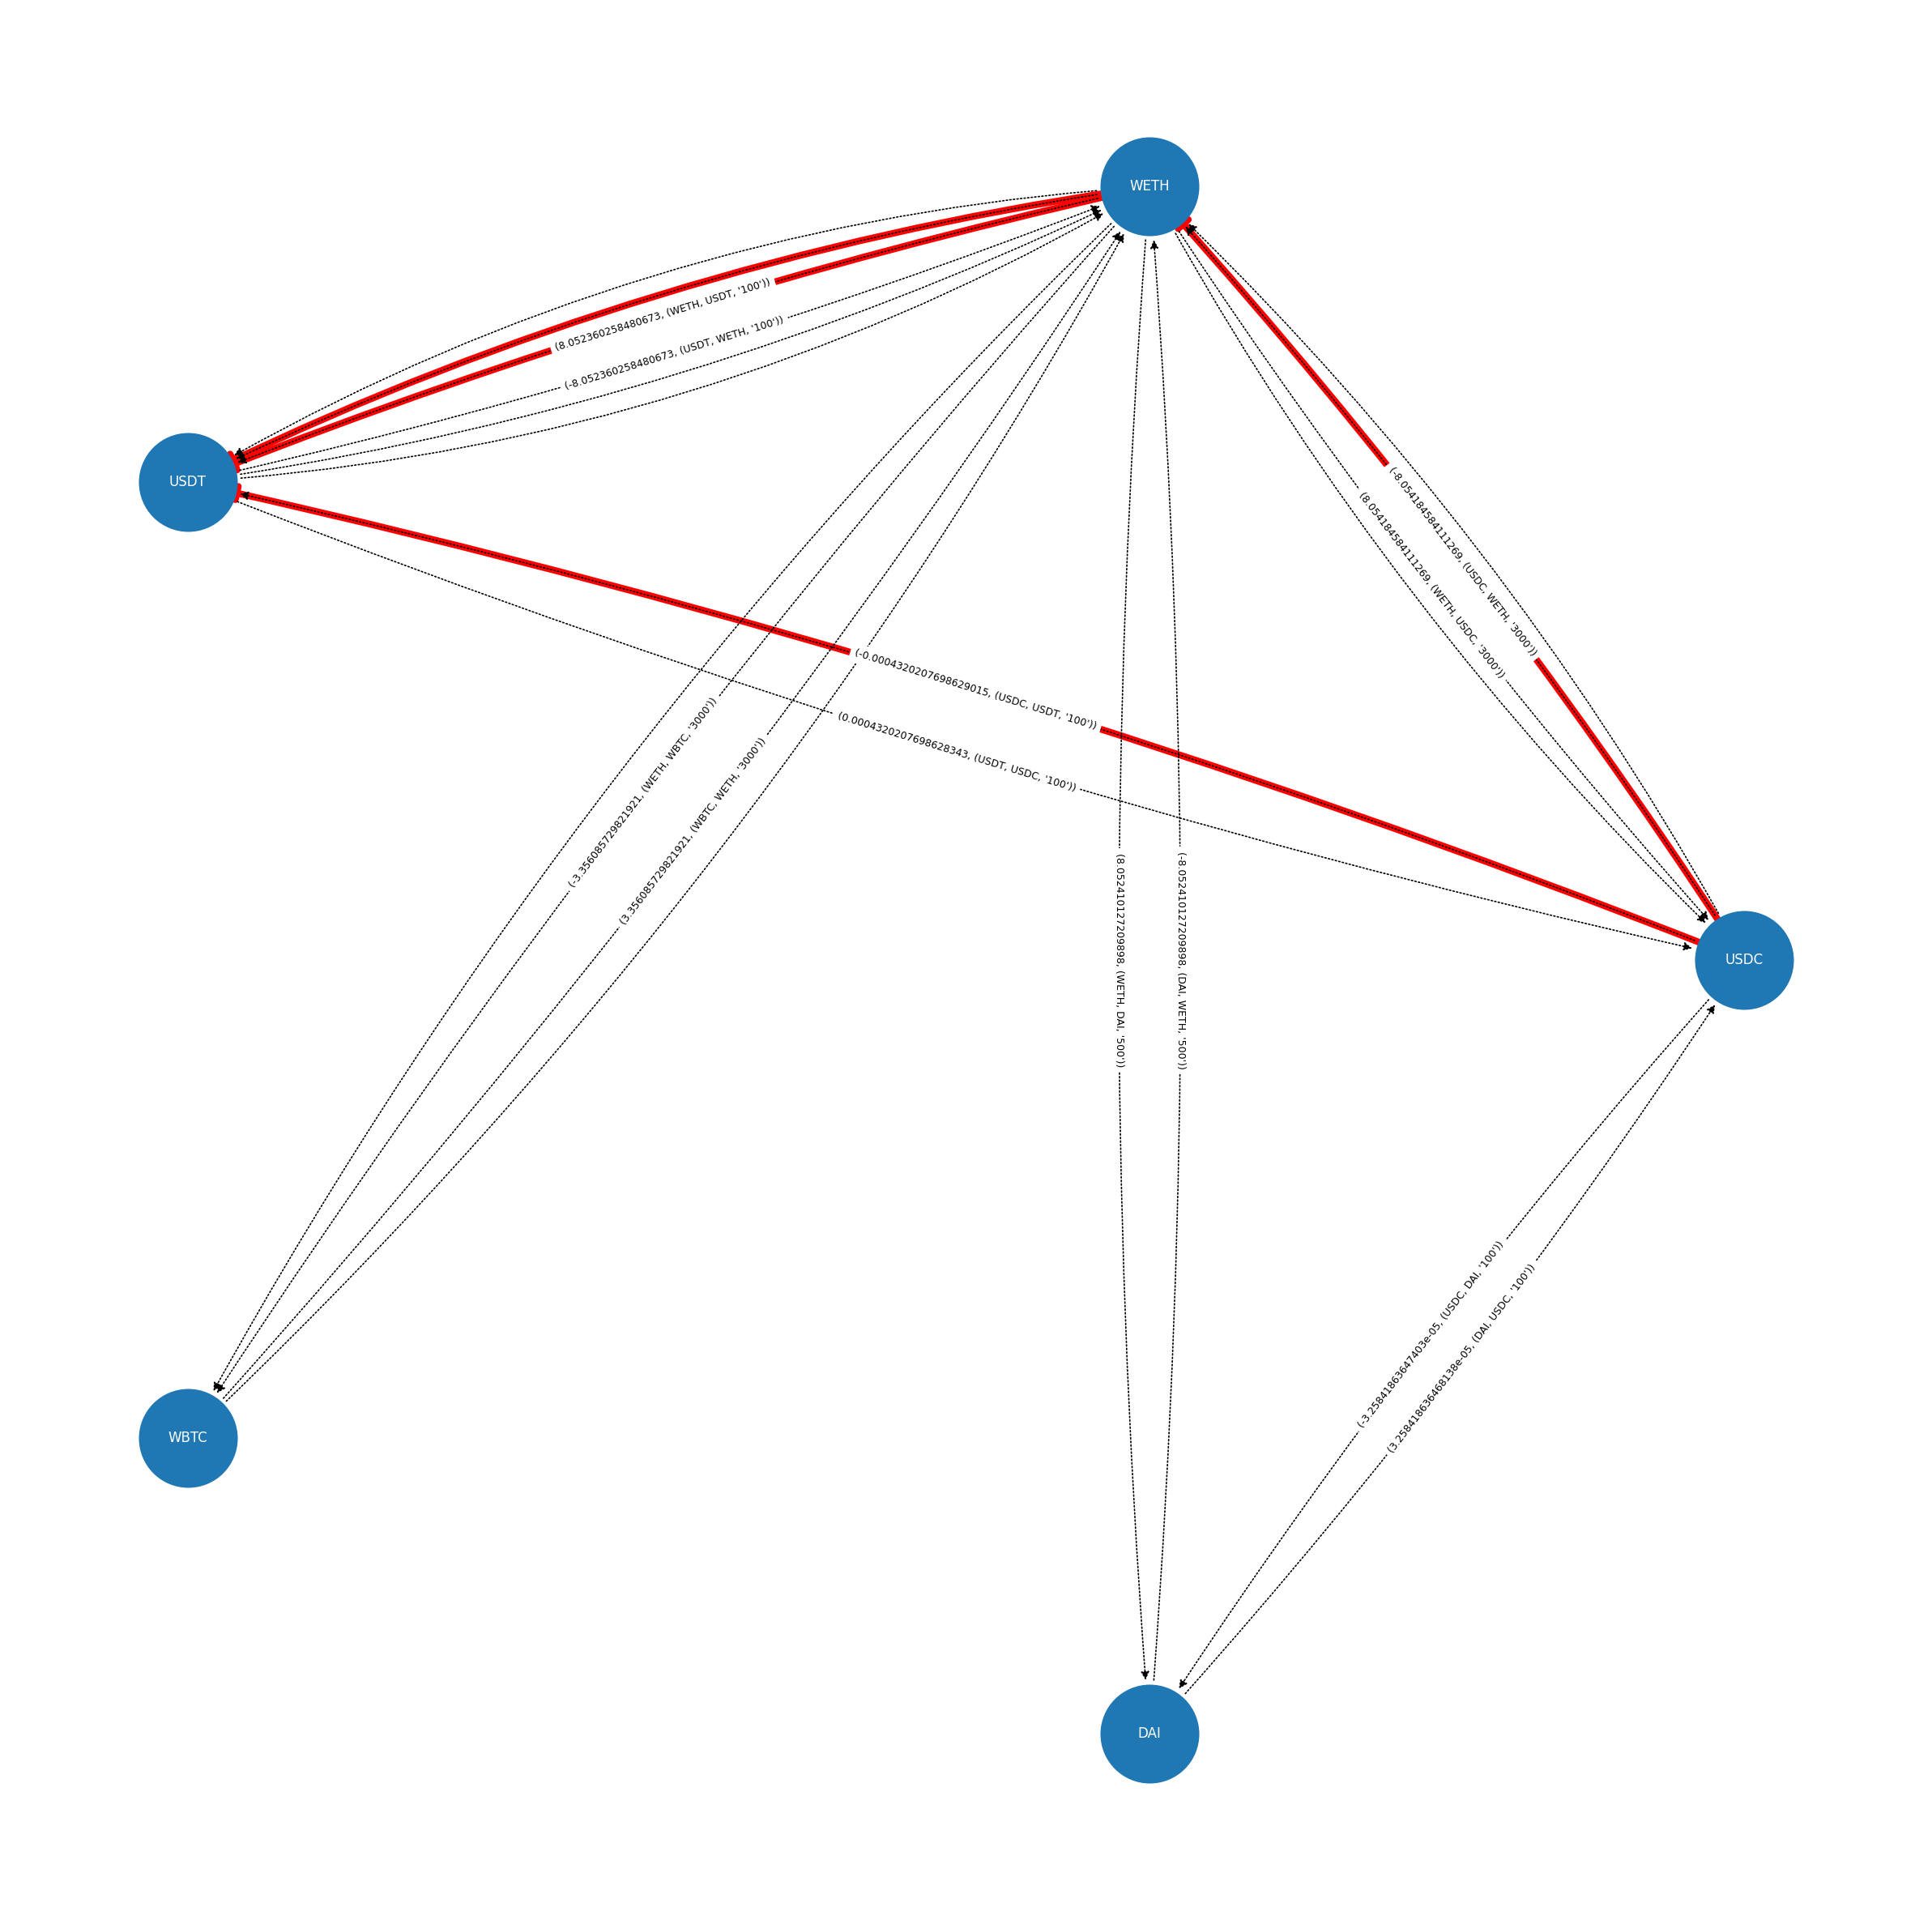

In [14]:
import networkx as nx
import matplotlib.pyplot as plt
import itertools as it

G = nx.MultiDiGraph()
print(edges)
print(g.vertices)
G.add_weighted_edges_from(edges)
plt.figure(3, figsize=(10, 10), dpi=300)
pos = nx.circular_layout(G)

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_color="tab:blue", node_size=800)
connectionstyle = [f"arc3,rad={r}" for r in it.accumulate([0.04] * 4)]


# Draw negative cycle
C = nx.MultiDiGraph()
C.add_weighted_edges_from(printable_neg_cycle)
nx.draw_networkx_edges(C, pos, edge_color="red", width=2, connectionstyle=connectionstyle)


# Draw edges
nx.draw_networkx_edges(
    G,
    pos,
    edge_color="black",
    width=0.4,
    connectionstyle=connectionstyle,
    min_source_margin=5,
    min_target_margin=5,
    style="dotted",
    arrowsize=5,
    node_size=1000,
)

# Draw labels
nx.draw_networkx_labels(
    G, pos, font_size=4, font_family="sans-serif", font_color="white"
)
nx.draw_networkx_edge_labels(
    G,
    pos,
    font_size=3,
    connectionstyle=connectionstyle,
    edge_labels={(u, v): d["weight"] for u, v, d in G.edges(data=True)},
)

plt.axis("off")
plt.show()